In [23]:
# import new_adventure as na
# import new_adventure.derivative_free_estimation as dfe
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import yaml
import pickle

from utils import convert_opt_path

%load_ext autoreload
%autoreload 2

def load_opt_path(experiment_folder, process_id):
    with open(os.path.join(experiment_folder, process_id, "results.pkl"), "rb") as f:
        all_paths = pickle.load(f)
    return all_paths

%matplotlib inline
plt.rcParams['figure.figsize'] = [16,8]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# exp_path = "/Users/daniellengyel/new_adventure/experiments/MAXQ/"
# exp_path = "/rds/general/user/dl2119/home/new_adventure/experiments/linear/"
exp_path = "/vol/bitbucket/dl2119/new_adventure/experiments/linear/"

# label = 
# folder_name = 
# exp_id = 
# exp_path = 

bfgs_folder = "BFGS_Jul09_13-27-21_kingfisher.doc.ic.ac.uk"
bfgs_id = "1625833641.4432719"
bfgs_path = load_opt_path(exp_path + bfgs_folder, bfgs_id)

newton_folder = "Newton_IPM_Jul09_13-17-16_kingfisher.doc.ic.ac.uk"
newton_id = "1625833036.607114"
newton_path = load_opt_path(exp_path + newton_folder, newton_id)

shift_folder = "Newton_shift_est_IPM_Jul09_13-18-01_kingfisher.doc.ic.ac.uk"
shift_id = "1625833081.0258617"
shift_path = load_opt_path(exp_path + shift_folder, shift_id)

shift_multi_folder = "Newton_IPM_Jul09_13-16-32_kingfisher.doc.ic.ac.uk"
shift_multi_id = "1625832992.2236726"
shift_multi_path = load_opt_path(exp_path + shift_multi_folder, shift_multi_id)

In [25]:


bfgs_vals = convert_opt_path(bfgs_path)
bfgs_vals[:, 1] -= bfgs_vals[1, 1]
newton_vals = convert_opt_path(newton_path)
newton_vals[:, 1] -= newton_vals[1, 1]
shift_vals = convert_opt_path(shift_path)
shift_vals[:, 1] -= shift_vals[1, 1]
shift_multi_vals = convert_opt_path(shift_multi_path)
shift_multi_vals[:, 1] -= shift_multi_vals[1, 1]

# bfgs_vals = np.array([[[np.sum(p[i][0]), p[i][1]] for i in range(len(p))] for p in bfgs_path ]).reshape(-1, 2)
# newton_vals = np.array([[[np.sum(p[i][0]), p[i][1]] for i in range(len(p))] for p in newton_path ]).reshape(-1, 2)
# shift_vals = np.array([[[np.sum(p[i][0]), p[i][1]] for i in range(len(p))] for p in shift_path ]).reshape(-1, 2)

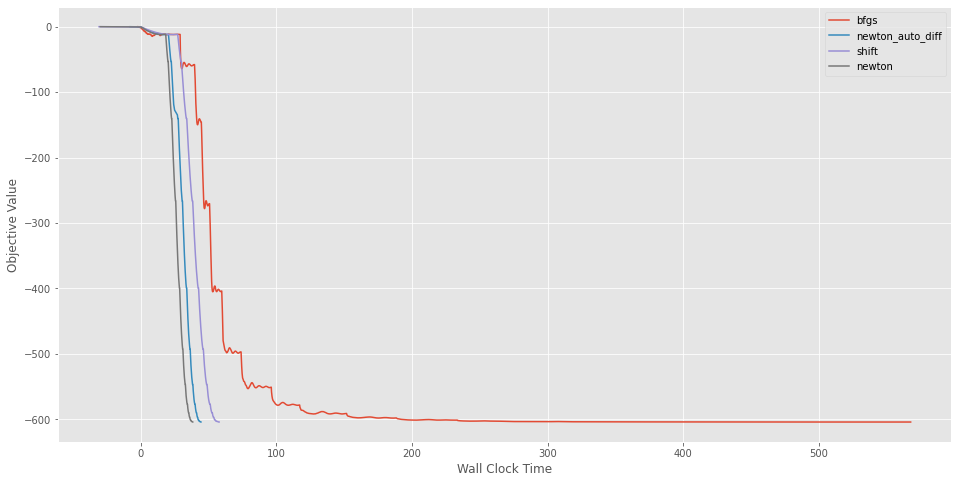

In [26]:
plt.plot(bfgs_vals[:, 1], bfgs_vals[:, 0], label="bfgs")
plt.plot(newton_vals[:, 1], newton_vals[:, 0], label="newton_auto_diff")
plt.plot(shift_vals[:, 1], shift_vals[:, 0], label="shift")
plt.plot(shift_multi_vals[:, 1], shift_multi_vals[:, 0], label="newton")

plt.legend()
# plt.ylim(-6000, -5500)
plt.xlabel("Wall Clock Time")
plt.ylabel("Objective Value")
# plt.yscale('log')
plt.show()

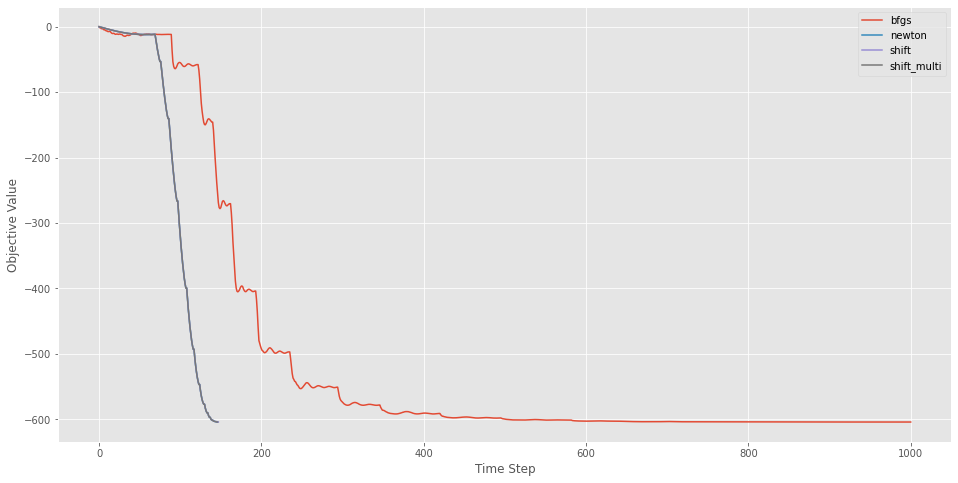

In [27]:
plt.plot(bfgs_vals[:, 0], label="bfgs")
plt.plot(newton_vals[:, 0], label="newton")
plt.plot(shift_vals[:, 0], label="shift")
plt.plot(shift_multi_vals[:, 0], label="shift_multi")

plt.legend()
# plt.ylim(-6000, -5500)
plt.xlabel("Time Step")
plt.ylabel("Objective Value")
# plt.yscale('log')
plt.show()

In [37]:
def path_distance(path1, path2):
    res = []
    if len(path1) < len(path2):
        shorter = path1
        longer = path2
    else:
        shorter = path2
        longer = path1
        
    longer_j = 0
    for i in range(len(shorter)):
        longer_j = i
#         print(longer_j)
        while ((longer_j + 1) < len(longer)) and (np.linalg.norm(shorter[i] - longer[longer_j]) > np.linalg.norm(shorter[i] - longer[longer_j+1])):
            longer_j += 1
        res.append(np.linalg.norm(shorter[i] - longer[longer_j]))
        if longer_j == len(longer) - 2:
            break
        
        
    for i in range(min(len(path1), len(path2))):
        res.append(np.linalg.norm(path1[i] - path2[i]))
    return res

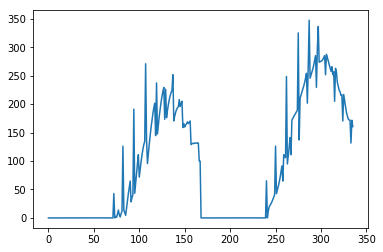

In [40]:
plt.plot(path_distance(shift_vals[:, 0], newton_vals[:, 0]))

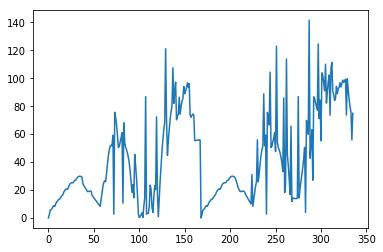

In [42]:
plt.plot(path_distance(bfgs_vals[:, 0], newton_vals[:, 0]))

In [29]:
t = 10
a = bfgs_path[t][-1][0]
# b = shift_path[t][-1][0]
# np.linalg.norm(a - b)

In [17]:
np.random.seed(10)
dim = 50
num_barriers = 2000
dirs = np.random.normal(size=(num_barriers, dim)) # sample gaussian and normalize 
ws = dirs/np.linalg.norm(dirs, axis=1).reshape(-1, 1)
bs = np.ones(num_barriers)


barrier = na.Barriers.LogPolytopeBarrier(ws, bs)

F = na.Functions.Linear(np.ones(dim))

F = barrier # na.Functions.LinearCombination(F, barrier, [1, 1])

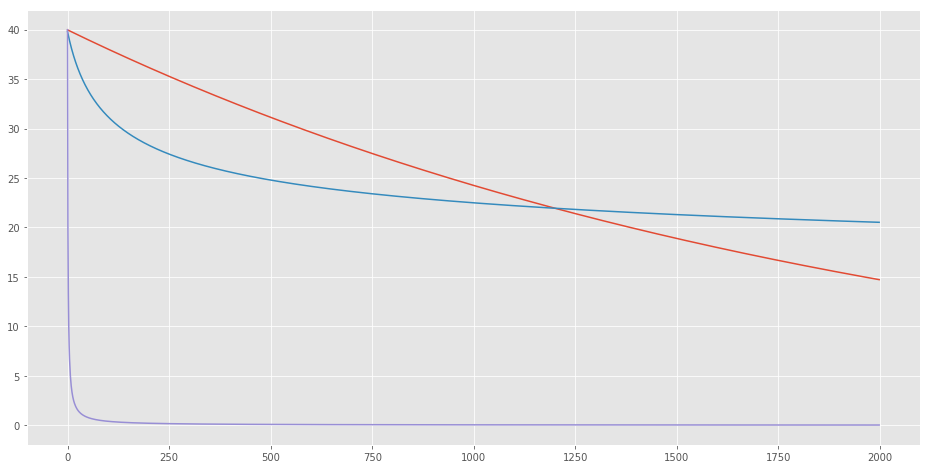

In [49]:
res1 = []
res2 = []
res3 = []
sigma = 40
for t in range(1, 2000):
    res1.append(sigma * np.e**(- 0.0005 * t)) #sigma * 1/(1 + np.log(t)/np.log(100)))
    res2.append(sigma * 1/(np.log(t + 50)/np.log(50)))
    res3.append(sigma / float(t))

plt.plot(res1)
plt.plot(res2)
plt.plot(res3)

In [ ]:
[[-4.08653571, -4.13286989, -3.95076614, -4.15547513, -3.49994787, -3.57026795,
  -3.7938423 , -4.12136015, -3.65786342, -4.07157976, -4.2349544 , -3.428094,
  -4.23294738, -4.23543057, -4.01950864, -4.22205812, -4.1754283 , -3.99612619,
  -3.41018688, -4.0687547 , -3.67556994, -3.84908772, -3.98871223, -3.86126325,
  -3.36466582, -3.3261831 , -4.21375671, -4.29674189, -4.21564043, -4.28309616,
  -4.23919035, -3.89637401, -4.29584853, -3.82188051, -4.1372486 , -4.20578596,
  -3.83789293, -4.23093461, -3.8112112 , -3.7979367 , -4.16727839, -3.93755917,
  -3.86394499, -3.83850989, -4.28515094, -3.93463323, -3.61277935, -3.66578832,
  -3.68904054, -4.07395594, -3.39706506, -3.8093003 , -3.90893972, -4.2108115,
  -4.03895986, -4.23518914, -3.68259048, -3.69635024, -3.28611546, -4.30379517,
  -4.07922212, -3.50977417, -4.1484698 , -3.53270307, -4.06869231, -3.41841916,
  -4.05838022, -3.68581409, -4.07195305, -3.90964769, -3.96420945, -4.09866475,
  -4.06873767, -3.74638503, -4.12283425, -3.56686407, -3.47421458, -3.45025409,
  -3.65747365, -3.70107743, -4.15962439, -4.29960385, -4.11018416, -3.18124287,
  -3.56384593, -3.65123884, -4.00761417, -4.25759951, -3.88235651, -3.69468319,
  -4.03985722, -4.06003586, -4.08625979, -4.11675827, -4.16695674, -3.65293747,
  -4.25515595, -3.83481097, -3.9418322 , -3.30547283,]]

In [ ]:
16.66936421523405 10, 50000
 16.793206063857202 25, 50000
16.93358325097884 25, 50000
16.79830077199056 50, 50000
15.748634339761466 5, 50000 ? 
7.093615047352767 1, 75000
15.085192701452694 1, 10000